In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from lightgbm import LGBMClassifier
from skopt import gp_minimize, load
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.datasets import load_breast_cancer
import warnings
warnings.filterwarnings("ignore")

/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Load data

In [2]:
df = load_breast_cancer()

In [3]:
X = pd.DataFrame(data = df.data, columns = df.feature_names)
X.shape

(569, 30)

In [4]:
y = df.target
y.shape

(569,)

# Define search space

In [5]:
space  = [Integer(1, 100, name='n_iter'),
          Real(0.01, 0.1,  name='learning_rate'),
          Integer(1, 20, name='max_depth'),
          Real(0.1, 1, name='feature_fraction'),
          Real(0.01, 10, "log-uniform", name='min_split_gain')]

# Define objective function

We define the objective function for this classification task as the cross validated AUC. Note that a minus sign is added to the AUC since the objective function is being minimized rather than maximized.

In [6]:
#use_named_args allows hyperparameters to be set by name directly
@use_named_args(space)
def objective(**params):
    clf = LGBMClassifier(objective = 'binary',
                     metric = 'auc',
                     random_state = 0,
                     n_thread = -1)
    
    clf.set_params(**params)
    
    #print the current set of hyperparameters
    print("Tested hyperparameters:")
    for param, value in params.items():
        print(f"{param}: {value}")

    return -np.mean(cross_val_score(clf, X, y, scoring = 'roc_auc', cv = 5))

We store all evaluations in the checkpointsaver.

In [7]:
checkpoint_saver = CheckpointSaver("./checkpoint.pkl", compress=9)

In [15]:
try:
    #Load previous evaluations if there are any. Else initialize with random search points.
    result = load('./checkpoint.pkl')

    x_init = result.x_iters
    y_init = result.func_vals
except:
    x_init = None
    y_init = None
finally:
    result = gp_minimize(objective,
                         space,
                         x0 = x_init,
                         y0 = y_init,
                         n_calls=50,
                         n_random_starts = 10,
                         callback = [checkpoint_saver],
                         verbose = True,
                         random_state = 0)

Iteration No: 1 started. Evaluating function at random point.
Tested hyperparameters:
n_iter: 60
learning_rate: 0.08598391737229158
max_depth: 17
feature_fraction: 0.8625265649057131
min_split_gain: 0.7424908231815013
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1434
Function value obtained: -0.9913
Current minimum: -0.9913
Iteration No: 2 started. Evaluating function at random point.
Tested hyperparameters:
n_iter: 39
learning_rate: 0.036778114589002514
max_depth: 2
feature_fraction: 0.3453906651221019
min_split_gain: 0.2710162626224753
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1110
Function value obtained: -0.9870
Current minimum: -0.9913
Iteration No: 3 started. Evaluating function at random point.
Tested hyperparameters:
n_iter: 81
learning_rate: 0.053197945513755174
max_depth: 8
feature_fraction: 0.85247088718364
min_split_gain: 0.10284625479837635
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1703
Functi

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.5159
Function value obtained: -0.9915
Current minimum: -0.9928
Iteration No: 25 started. Searching for the next optimal point.
Tested hyperparameters:
n_iter: 61
learning_rate: 0.011271426631144436
max_depth: 17
feature_fraction: 0.2089087355917573
min_split_gain: 0.012423728708443387
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.4818
Function value obtained: -0.9888
Current minimum: -0.9928
Iteration No: 26 started. Searching for the next optimal point.
Tested hyperparameters:
n_iter: 67
learning_rate: 0.09873966394797257
max_depth: 3
feature_fraction: 0.3128220348136193
min_split_gain: 0.09899849870774707
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.4933
Function value obtained: -0.9940
Current minimum: -0.9940
Iteration No: 27 started. Searching for the next optimal point.
Tested hyperparameters:
n_iter: 100
learning_rate: 0.09087

Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 0.6003
Function value obtained: -0.9856
Current minimum: -0.9940
Iteration No: 48 started. Searching for the next optimal point.
Tested hyperparameters:
n_iter: 48
learning_rate: 0.1
max_depth: 20
feature_fraction: 0.1
min_split_gain: 0.08079846832527712
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 0.5546
Function value obtained: -0.9906
Current minimum: -0.9940
Iteration No: 49 started. Searching for the next optimal point.
Tested hyperparameters:
n_iter: 31
learning_rate: 0.022927961402567455
max_depth: 2
feature_fraction: 0.2649140803503053
min_split_gain: 0.01011377409945414
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 0.5844
Function value obtained: -0.9874
Current minimum: -0.9940
Iteration No: 50 started. Searching for the next optimal point.
Tested hyperparameters:
n_iter: 48
learning_rate: 0.1
max_depth: 20
feature_fraction: 1.0


# Plot results

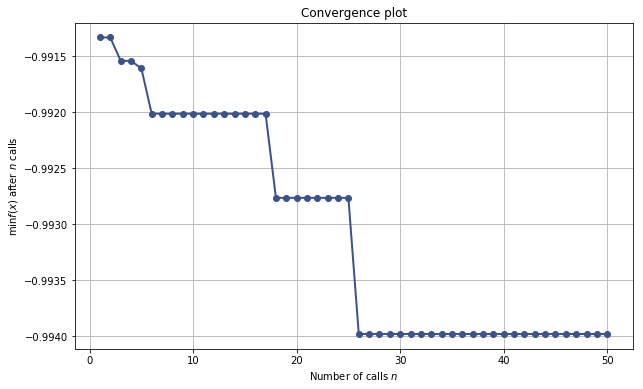

In [16]:
plt.figure(figsize=(10, 6))
plot_convergence(result)
plt.show()

We plot the results in order to see how the objective function is converging.

# Store results

In [10]:
#store list of parameters we explore in the search space
param_list = []
for elem in space:
    param_list.append(elem.name)

In [11]:
result_df = pd.DataFrame(result.x_iters, columns = param_list)
result_df['AUC'] = -result.func_vals
result_df.head()

,n_iter,learning_rate,max_depth,feature_fraction,min_split_gain,AUC
0,60,0.085984,17,0.862527,0.742491,0.991335
1,39,0.036778,2,0.345391,0.271016,0.987030
2,81,0.053198,8,0.852471,0.102846,0.991543
3,65,0.043142,19,0.226316,4.076259,0.988316
4,48,0.082082,11,0.710992,1.451770,0.991610


# Display best parameters

In [12]:
result_df.loc[result_df['AUC'].idxmax()]

n_iter              67.000000
learning_rate        0.098740
max_depth            3.000000
feature_fraction     0.312822
min_split_gain       0.098998
AUC                  0.993980
Name: 25, dtype: float64